In [1]:
import matplotlib.pyplot as plt
import requests, json
import pandas as pd
import upsetplot 
from upsetplot import generate_counts, UpSet
import numpy as np
import seaborn as sns
import random
import statistics
import os
import sys
from typing import Union
from pathlib import Path

In [2]:
def apply_mapping(value, mapping_dict):
    return mapping_dict.get(value, value)  # If value not found in dictionary, return the original value

def genes_present_in_df(list_GO_genes, list_TF_Prio_pred):
    df_values = set(list_TF_Prio_pred)
    filtered_results = [item for item in list_GO_genes if item in df_values]
    return filtered_results

def read_in_gene_ontology_file(file):
    """Reads in GO term files. Adjusts for the shift in the column names,
    e.g. first column name is "index" and the extra NaN value column as the last columns as a result of
    the col name shift. Also changes the the HGNC symbol to upper to make it easier comparable to other genes.
    """
    go_info = pd.read_csv(file, sep="\t").reset_index()
    go_info.columns.values[:11] = go_info.columns.values[1:]
    go_info = go_info.iloc[:, :-1]
    go_info["Symbol"] = go_info["Symbol"].str.upper()
    return go_info

def read_go_files_in_dir(path):
    """Takes a path (to the GO annotations) as input, reads them as dataframes in 
    and gives a dictionary of all GO annotations back with the file names as keys.
    """
    file_names_list = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    go_dict = {}
    for file_name in file_names_list:
        file_path = os.path.join(path, file_name)
        changed_file_name = file_name.split(".")[0]
        go_dict[changed_file_name] = list(set(read_in_gene_ontology_file(file_path)["Symbol"]))
    return go_dict

def create_dfs_for_heatmap(go_dir_path, comparison_main_dir, path_to_all_tfs_file):
    go_dict = read_go_files_in_dir(go_dir_path)
    top_tf_dict = read_multiple_top_tfs_from_comparison_folder(comparison_main_dir)
    all_tfs = pd.read_csv(path_to_all_tfs_file, sep="\t").columns.values
    all_tfs = adjust_tfprio_used_TF(all_tfs)
    df_overlap = pd.DataFrame()
    df_p_value = pd.DataFrame()
    for comparison_name, tf_list in top_tf_dict.items():
        new_overlap_col_df, new_p_value_col_df = over_representation_analysis(tf_list, all_tfs, go_dict, colname=comparison_name)
        df_overlap = pd.concat([df_overlap, new_overlap_col_df], axis=1)
        df_p_value = pd.concat([df_p_value, new_p_value_col_df], axis=1)
    
    return df_overlap, df_p_value

def read_multiple_top_tfs_from_comparison_folder(comparison_main_dir):
    """As input directory a main comparisonfodler should be given,
    e.g. /nfs/data3/IHEC/TF_PRIO/comparisons/cells. Based on the input folder
    it iterates through every subdirectory and if this subdirectory contains the top TF
    list files (dcg.tsv), it will read them out and, together with the celltypes and chromatin status,
    and return all TFs as lists as value and with the according name of the folder as key in a dictionary.
    """
    
    dir_list = [path.path for path in os.scandir(comparison_main_dir) if path.is_dir()]
    top_tf_dict = {}
    for dir_path in dir_list:
        celltype1, celltype2, chromatin_status = get_involved_celltypes_and_chromatin_status(dir_path)
        top_tf_comparison_name = "-".join([celltype1, celltype2, chromatin_status])
        top_tfs = read_out_top_tf_from_comparison_folder(dir_path)
        if top_tfs is not None:
            top_tf_dict[top_tf_comparison_name] = top_tfs
    return top_tf_dict

def get_involved_celltypes_and_chromatin_status(path):
    #path = "/nfs/data3/IHEC/TF_PRIO/comparisons/cells/b-cells-healthy-b-cells-leukemia-H3K27ac-H3k36me3-H3K4me1-H3K4me3-mRNA-totalRNA"
    comparison = path.split("/")[-1] 
    possible_celltypes = ["b-cells-healthy", "b-cells-leukemia", "t-cells-healthy", "t-cell-healthy", 
                          "macrophage-healthy", "myeloid-cells-leukemia", "neutrophil-healthy", "monocyte-healthy"]
    celltype1 = "-".join(comparison.split("-")[0:3])
    if celltype1 not in possible_celltypes:
        celltype1 = "-".join(comparison.split("-")[0:2])
        if celltype1 not in possible_celltypes:
            celltype1 = "-".join(comparison.split("-")[0:3])
            print("Unknown first celltype. Inferred name for column might look weird: "+str(celltype1))
            print("used path: "+str(path))
    
    celltype2 = "-".join(comparison.split("-")[3:6])
    if celltype2 not in possible_celltypes:
        celltype2 = "-".join(comparison.split("-")[3:5])
        if celltype2 not in possible_celltypes:
            celltype2 = "-".join(comparison.split("-")[2:5])
            if celltype2 not in possible_celltypes:
                celltype2 = "-".join(comparison.split("-")[2:4])
                if celltype2 not in possible_celltypes:
                    celltype2 = "-".join(comparison.split("-")[2:5])
                    print("Unknown second celltype. Inferred name for column might look weird: "+str(celltype2))
                    print("used path: "+str(path))
            
            
    #celltype1  , celltype2 = comparison.split("-")[0]+"-"+comparison.split("-")[1], comparison.split("-")[3]+"-"+comparison.split("-")[4]
    celltype1  , celltype2 = "-".join(comparison.split("-")[0:3]), "-".join(comparison.split("-")[3:6])
    if "H3K27ac-H3k36me3-H3K4me1-H3K4me3" in path or "H3K27ac-H3K36me3-H3K4me1-H3K4me3" in path:
        chromatin_status = "euchromatin"
    elif "H3K27me3-H3K4me3-H3K9me3" in path:
        chromatin_status = "heterochromatin"
    else:
        #(maybe): TODO - improve custom HM combination detection
        print("The given path "+str(path)+" does no contain standard eu- or heterochromatin histonmarkers. \n Instead of the chromatin status, the combination of histon markers will be used as name.")
        chromatin_status = "custom-HM-combination"
        
    print(celltype2)
    return celltype1, celltype2, chromatin_status

def read_out_top_tf_from_comparison_folder(comparison_path: Union[str, Path], modus: Union["list", "dataframe"]="list"):
    """Takes a path, checks it if it contains a directory with the top  TFs of the TF Prio run,
    and if so, reads the top TFs out and returns them as a list.
    """
    print(comparison_path)
    if not os.path.isdir(comparison_path):
        print("The used path "+str(comparison_path)+" does not exist")
        #Pass
        return None
    else:
        file_path = os.path.join(comparison_path,"output/output/org_exbio_tfprio_steps_distributionAnalysis_CalculateDcgRank/output/dcg.tsv")
        if not os.path.isfile(file_path):
            print("There is no dcg.tsv file for the given folder"+str(os.path.join(comparison_path,"output/output/org_exbio_tfprio_steps_distributionAnalysis_CalculateDcgRank/output")))
            #pass
            return None
        else:
            #print(file_path)
            if os.path.getsize(file_path) == 0:
                print("File at "+str(file_path)+" is empty. File will be deleted.")
                os.remove(file_path)
            else:
                print("Found top_tf file at: "+str(file_path))
                top_tf_df = pd.read_csv(file_path, sep="\t")
                if modus == "list":
                    return list(top_tf_df["TF"])
                elif modus == "dataframe":
                    return top_tf_df
    

def adjust_tfprio_used_TF(tf_list):
    """Takes the list of all used TFs by TFPrio and changes the names of the TFs in it.
    E.g. NFIC::TLX1 to NFIC or JUND(MA0492.1) to JUND. After this also removes duplicates.
    TODO: just as 
    """
    new_tf_list = list(set([x.split("(")[0] for x in[x.split(":")[0] for x in tf_list]]))
    return new_tf_list

def over_representation_analysis(gene_list, background_genes_list, gene_set_dictionary={}, colname = ""):
    """Takes a list of genes, a dictionary of the gene sets to which the list of genes should be compared against,
    a list of background genes and the column-name of the new created column for the dataframes.
    If no column-name is given, the string name of the gene_list is used.
    """
    enr = gp.enrich(gene_list=gene_list,
                   gene_sets=gene_set_dictionary,
                   background=background_genes_list)
    
    overlap_dict = {}
    p_value_dict = {}
    for index, row in enr.results.iterrows():
        overlap_dict[row["Term"]] = row["Overlap"]
        p_value_dict[row["Term"]] = row["Adjusted P-value"]
    if not colname:
        colname = str(gene_list)
        
    all_sets = list(gene_set_dictionary.keys())
    term_with_overlap = list(enr.results["Term"])
    terms_with_no_overlap = [term for term in all_sets if term not in term_with_overlap]
    if len (terms_with_no_overlap) > 0:
        for term in terms_with_no_overlap:
            overlap_dict[term] = "0/"+str(len(gene_set_dictionary[term]))
            p_value_dict[term] = 1
    
    overlap_df_col = pd.DataFrame.from_dict(overlap_dict, orient="index", columns=[colname])
    p_value_df_col = pd.DataFrame.from_dict(p_value_dict, orient="index", columns=[colname])
    return overlap_df_col, p_value_df_col

In [3]:
tf_color = "#A700FC"
dark_tf_color = "#00306F"
tg_color = "#FF3CFE"

In [4]:
#pip install gprofiler-official

In [ ]:
#import gseapy as gp
#pip install biomart
#pip install bioservices
#pip install mousipy
#pip install mygene
#pip install scvelo
#pip install gseapy
#import numpy
#pip uninstall numpy
#pip install gseapy
#pip install pyupset

- Welche Unterschiede sind zwischen Acetylierung und Methylierung zu sehen, welche HM öffnert DNA und welche schließt sie?
- Was ist der Unterschied zwischen Maus und Mensch, sind die TFs die sehr ähnlich sind homologe?
- UPset Plot, übersicht über alle daten, sind immer die selben TFs im Spiel oder eher verschiedene
- Ein paar interessante reports rauspicken um genauer darüber zu schreiben (am besten von Kraknheit bei Menschen, da gibts die meiste Literatur dazu)
- Maybe: vergelichen von verschiedenen Krebs Arten/ von Krebs mit healthy
- Andere Idee: unterschiede zwischen Protocols (atac vs. dnase)
-----
- Hubs in TF regulating TF research
- Algnment/conserved genes find in Prio TF/TG to write more about them?
- Correlation between number of genes and number of Prioritized TF?
- DOWNLOAD MOUSE!!
- [README for download!]

1. Download_data.py
2. delete archived
3. unzip
4. rename
5. create gene ids

## Intestin Mouse vs Human

In [180]:
human_tfs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/human_embryo_stem/dcg.tsv", sep="\t")
mouse_tfs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/mouse_embryo_stem/dcg.tsv", sep="\t")

human_tgs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/human_embryo_stem/top_tgs.tsv", sep="\t")
mouse_tgs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/mouse_embryo_stem/top_tgs.tsv", sep="\t")

In [181]:
data = {
    'human': human_tfs["TF"],
    'mouse': mouse_tfs["TF"],
}
df = pd.DataFrame(data)
#print(df)

In [12]:
from gseapy import Biomart
bm = Biomart()
# mouse
mouse_ensembl_2_mouse_symbol = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name'])

mouse_ensembl_2_mouse_symbol_dict_lower = {}
for i, row in mouse_ensembl_2_mouse_symbol.loc[:,["ensembl_gene_id", "external_gene_name"]].iterrows():
    if row.isna().any(): continue
    mouse_ensembl_2_mouse_symbol_dict_lower[row['ensembl_gene_id']] = row["external_gene_name"]

mouse_ensembl_2_mouse_symbol_dict = {}
for key in mouse_ensembl_2_mouse_symbol_dict_lower:
    value = mouse_ensembl_2_mouse_symbol_dict_lower[key]
    mouse_ensembl_2_mouse_symbol_dict[key.upper()] = value.upper()

#human
human_ensembl_2_human_symbol = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name'])

human_ensembl_2_human_symbol_dict_lower = {}
for i, row in human_ensembl_2_human_symbol.loc[:,["ensembl_gene_id", "external_gene_name"]].iterrows():
    if row.isna().any(): continue
    human_ensembl_2_human_symbol_dict_lower[row['ensembl_gene_id']] = row["external_gene_name"]

human_ensembl_2_human_symbol_dict = {}
for key in human_ensembl_2_human_symbol_dict_lower:
    value = human_ensembl_2_human_symbol_dict_lower[key]
    human_ensembl_2_human_symbol_dict[key.upper()] = value.upper()

In [7]:
#mouse_intestine_tgs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/mouse_small_intestine_vs_intestine/top_tgs.tsv", sep="\t")
#mouse_intestine_tgs['Symbol'] = mouse_intestine_tgs['TG'].apply(lambda x: apply_mapping(x, mouse_ensembl_2_mouse_symbol_dict))
#df['mouse_intestine_trans_human'] = df['mouse_intestine'].apply(lambda x: apply_mapping(x, m2h_dict))

In [6]:
# From tutorial GO converting human into mouse gene symbols:
from gseapy import Biomart
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [34]:
h2m

ensembl_gene_id external_gene_name mmusculus_homolog_ensembl_gene   
0      ENSG00000210049              MT-TF                            NaN  \
1      ENSG00000211459            MT-RNR1                            NaN   
2      ENSG00000210077              MT-TV                            NaN   
3      ENSG00000210082            MT-RNR2                            NaN   
4      ENSG00000209082             MT-TL1                            NaN   
...                ...                ...                            ...   
77797  ENSG00000288629                NaN                            NaN   
77798  ENSG00000288678                NaN                            NaN   
77799  ENSG00000290825            DDX11L2                            NaN   
77800  ENSG00000227232             WASH7P                            NaN   
77801  ENSG00000290826                NaN                            NaN   

      mmusculus_homolog_associated_gene_name  
0                                        NaN  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  
...                                      ...  
77797                                    NaN  
77798                                    NaN  
77799                                    NaN  
77800                                    NaN  
77801                                    NaN  

[77802 rows x 4 columns]

In [39]:
# get a dict symbol mappings
h2m_dict_lower = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict_lower[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]

h2m_dict = {}
for key in h2m_dict_lower:
    value = h2m_dict_lower[key]
    h2m_dict[key.upper()] = value.upper()
    
m2h_dict_lower = {}
for i, row in m2h.loc[:,["external_gene_name", "hsapiens_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    m2h_dict_lower[row['external_gene_name']] = row["hsapiens_homolog_associated_gene_name"]

m2h_dict = {}
for key in m2h_dict_lower:
    value = m2h_dict_lower[key]
    m2h_dict[key.upper()] = value.upper()

In [38]:
h2m_dict_lower_ensemble = {}
for i, row in h2m.loc[:,["ensembl_gene_id", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict_lower[row['ensembl_gene_id']] = row["mmusculus_homolog_associated_gene_name"]

h2m_dict_ensemble  = {}
for key in h2m_dict_lower_ensemble:
    value = h2m_dict_lower_ensemble[key]
    h2m_dict_ensemble[key.upper()] = value.upper()

In [36]:
"""
num_TFs_pred = np.array([len(df["mouse"].dropna()), len(df["human"].dropna())])
num_TFs_total = np.array([1000.0, 1600.0])
plt.plot(num_TFs_pred, num_TFs_total, 'o', color='#009175')
m, b = np.polyfit(num_TFs_pred, num_TFs_total, 1)
plt.plot(num_TFs_pred,m*num_TFs_pred+b, color='black')

print(np.corrcoef(num_TFs_pred,num_TFs_total))
"""

'\nnum_TFs_pred = np.array([len(df["mouse"].dropna()), len(df["human"].dropna())])\nnum_TFs_total = np.array([1000.0, 1600.0])\nplt.plot(num_TFs_pred, num_TFs_total, \'o\', color=\'#009175\')\nm, b = np.polyfit(num_TFs_pred, num_TFs_total, 1)\nplt.plot(num_TFs_pred,m*num_TFs_pred+b, color=\'black\')\n\nprint(np.corrcoef(num_TFs_pred,num_TFs_total))\n'

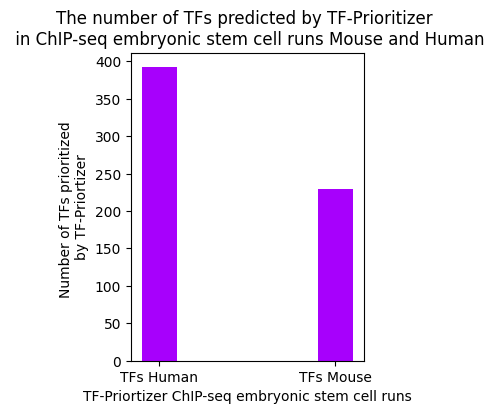

In [182]:
tf_human_num = len(df["human"].dropna())
tf_mouse_num = len(df["mouse"].dropna())

courses = ["TFs Human", "TFs Mouse"]
values = [tf_human_num, tf_mouse_num]
  
fig = plt.figure(figsize = (3, 4))
 
# creating the bar plot
plt.bar(courses, values, color =tf_color, 
        width = 0.2)
 
plt.xlabel("TF-Priortizer ChIP-seq embryonic stem cell runs")
plt.ylabel("Number of TFs prioritized \nby TF-Priortizer")
plt.title("The number of TFs predicted by TF-Prioritizer \n in ChIP-seq embryonic stem cell runs Mouse and Human")
plt.show()

Intersection: ['ZFX', 'ZFP57', 'IKZF1', 'FOXO4', 'SOX4', 'ARNT::HIF1A', 'PDX1', 'BATF3', 'HES1', 'MYB', 'POU2F1', 'FOXJ2', 'NEUROD1', 'CEBPD', 'NFATC3', 'NOBOX', 'FOXQ1', 'CLOCK', 'NEUROG2', 'ELF5', 'RUNX2', 'KLF8', 'NFATC4', 'GABPA', 'KLF1', 'CREB1', 'NR1H4', 'HOXA1', 'BARX1', 'MAFB', 'E2F5', 'GATA3', 'NR5A1', 'WT1', 'MYOG', 'STAT2', 'TCF3', 'TFAP2B', 'NFATC1', 'PITX1', 'SMAD2', 'FOXP2', 'RELB', 'MYOD1', 'EPAS1', 'ZBTB7A', 'FOS::JUN', 'LHX2', 'FOXC1', 'FOXO1', 'ARID5B', 'ETV6', 'FOSL2', 'HOXB5', 'EN1', 'RORA', 'CDX2', 'FOSB', 'KLF5', 'TCFL5', 'ZEB1', 'HOXD3', 'KLF6', 'HOXB8', 'MECP2', 'RUNX1', 'PAX5', 'NR4A2', 'TFAP2A', 'PBX2', 'ELF3', 'SRY', 'DLX3', 'MXI1', 'FOXO3', 'ARNT', 'PBX1', 'FOXD3', 'TBX6', 'SOX3', 'NFIL3', 'CRX', 'SOX10', 'NR2E3', 'ETV4', 'GATA2', 'TCF7L2', 'E2F6', 'RBPJ', 'SALL4', 'PRRX2', 'RORC', 'CEBPA', 'FOXA2', 'BARHL1', 'NR2F1', 'LHX6', 'SMAD4', 'GATA1', 'TBX3', 'TFAP2C', 'GRHL2', 'PAX4', 'NR2C1', 'OTX2', 'HIC1', 'HOXA5', 'NR4A1', 'HIF1A', 'NR2F2', 'KLF3', 'MBD2', 'CBF

<Figure size 900x1000 with 0 Axes>

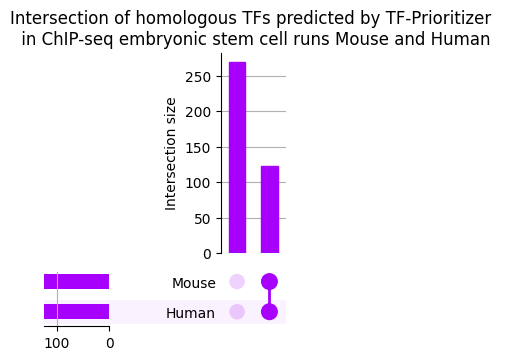

In [189]:
df['mouse_trans_human'] = df['mouse'].apply(lambda x: apply_mapping(x, m2h_dict))
intersection_result = set(df['human']).intersection(df['mouse_trans_human'])
intersection_list_TFs = list(intersection_result)
print("Intersection:", intersection_list_TFs)
print(len(intersection_list_TFs))

fig = plt.figure(figsize = (9, 10))

# Define the subset counts
tf_human_num = len(df["human"].dropna())
tf_mouse_num = len(df["mouse"].dropna())
inter_num = len(intersection_list_TFs)

# Create a data frame with zeros
data = pd.DataFrame(np.zeros((tf_human_num, 2), dtype=int), columns=['Human', 'Mouse'])

# Set values to 1 based on subset counts
#data['Human'] = 1
index = 0
data.loc[index:inter_num-1, 'Human'] = 1
data.loc[index:inter_num-1, 'Mouse'] = 1

upset_data = data[['Human', 'Mouse']]
example = upset_data.groupby(['Human', 'Mouse']).size()
upset = UpSet(example, facecolor=tf_color)
upset.plot()

plt.title('Intersection of homologous TFs predicted by TF-Prioritizer \n in ChIP-seq embryonic stem cell runs Mouse and Human')
plt.show()

In [67]:
human_intestine_tgs['TG']

3         ENSG00000132915
4         ENSG00000155850
5         ENSG00000200334
7         ENSG00000259054
8         ENSG00000211881
               ...       
435111    ENSG00000159882
435112    ENSG00000196793
435113    ENSG00000231494
435114    ENSG00000228884
435116    ENSG00000256943
Name: TG, Length: 308585, dtype: object

In [68]:
human_intestine_tgs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/human_embryo_stem/top_tgs.tsv", sep="\t")
human_intestine_tgs.columns = human_intestine_tgs.iloc[0]
human_intestine_tgs = human_intestine_tgs.rename(columns={human_intestine_tgs.columns[0]: 'Sample', 
                                                          human_intestine_tgs.columns[1]: 'TF', 
                                                          human_intestine_tgs.columns[2]: 'HM',
                                                          human_intestine_tgs.columns[3]: 'TG',
                                                          human_intestine_tgs.columns[4]: 'Score',})
human_intestine_tgs = human_intestine_tgs.iloc[1:]
# translating ensemble ids into gene symbols
human_intestine_tgs['Symbol'] = human_intestine_tgs['TG'].apply(lambda x: apply_mapping(x, human_ensembl_2_human_symbol_dict))
# filtering out genes without symbol translation
human_intestine_tgs = human_intestine_tgs[~human_intestine_tgs['Symbol'].str.contains('ENSG')]

mouse_intestine_tgs = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/mouse_embryo_stem/top_tgs.tsv", sep="\t")
mouse_intestine_tgs = mouse_intestine_tgs.rename(columns={mouse_intestine_tgs.columns[0]: 'Sample', 
                                                          mouse_intestine_tgs.columns[1]: 'TF', 
                                                          mouse_intestine_tgs.columns[2]: 'HM',
                                                          mouse_intestine_tgs.columns[3]: 'TG',
                                                          mouse_intestine_tgs.columns[4]: 'Score',})
mouse_intestine_tgs = mouse_intestine_tgs.iloc[1:]
mouse_intestine_tgs['Symbol'] = mouse_intestine_tgs['TG'].apply(lambda x: apply_mapping(x, mouse_ensembl_2_mouse_symbol_dict))
mouse_intestine_tgs['Symbol'] = mouse_intestine_tgs['Symbol'].apply(lambda x: apply_mapping(x, m2h_dict))
mouse_intestine_tgs = mouse_intestine_tgs[~mouse_intestine_tgs['Symbol'].str.contains('ENSMUSG')]

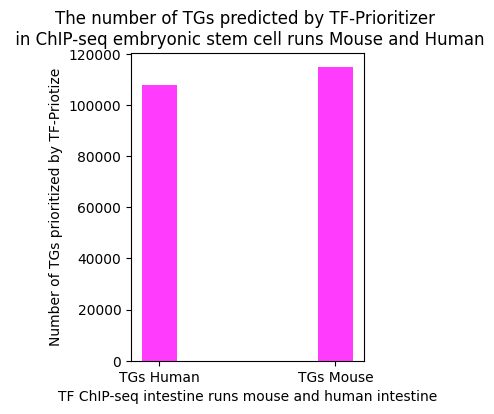

In [69]:
tf_human_num = len(human_intestine_tgs['Symbol'].dropna())
tf_mouse_num = len(mouse_intestine_tgs['Symbol'].dropna())

courses = ["TGs Human", "TGs Mouse"]
values = [tf_human_num, tf_mouse_num]
  
fig = plt.figure(figsize = (3, 4))
 
# creating the bar plot
plt.bar(courses, values, color =tg_color, 
        width = 0.2)
 
plt.xlabel("TF ChIP-seq intestine runs mouse and human intestine")
plt.ylabel("Number of TGs prioritized by TF-Priotize")
plt.title("The number of TGs predicted by TF-Prioritizer \n in ChIP-seq embryonic stem cell runs Mouse and Human")
plt.show()

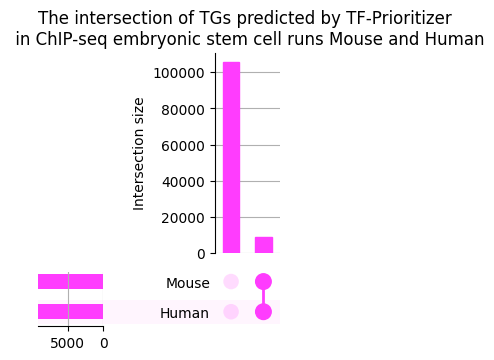

In [70]:
intersection_result = set(mouse_intestine_tgs['Symbol']).intersection(human_intestine_tgs['Symbol'])
intersection_list_TGs = list(intersection_result)
#print("Intersection:", intersection_list)
#print(len(intersection_list))

# Define the subset counts
tf_human_num = len(human_intestine_tgs['Symbol'].dropna())
tf_mouse_num = len(mouse_intestine_tgs['Symbol'].dropna())
inter_num = len(intersection_list_TGs)

# Create a data frame with zeros
data = pd.DataFrame(np.zeros((tf_mouse_num, 2), dtype=int), columns=['Human', 'Mouse'])

# Set values to 1 based on subset counts
#data['Human'] = 1
index = 0
data.loc[index:inter_num-1, 'Human'] = 1
data.loc[index:inter_num-1, 'Mouse'] = 1

upset_data = data[['Human', 'Mouse']]
example = upset_data.groupby(['Human', 'Mouse']).size()
upset = UpSet(example, facecolor=tg_color)
upset.plot()

plt.title('The intersection of TGs predicted by TF-Prioritizer \n in ChIP-seq embryonic stem cell runs Mouse and Human')
plt.show()

In [71]:
# are the TGs in the intersect regulated by TFs int the intersect?
mouse_intestine_tgs['TF'] = mouse_intestine_tgs['TF'].apply(lambda x: apply_mapping(x, m2h_dict))

df_intersect = mouse_intestine_tgs[mouse_intestine_tgs['TF'].isin(intersection_list_TFs) & mouse_intestine_tgs['Symbol'].isin(intersection_list_TGs)]
np_intersect_TF_reg_TG_mouse = np.unique(np.array(df_intersect["TF"]))
np_intersect_TG_reg_TF_mouse = np.unique(np.array(df_intersect["Symbol"]))

df_intersect = human_intestine_tgs[human_intestine_tgs['TF'].isin(intersection_list_TFs) & human_intestine_tgs['Symbol'].isin(intersection_list_TGs)]
np_intersect_TF_reg_TG_human = np.unique(np.array(df_intersect["TF"]))
np_intersect_TG_reg_TF_human = np.unique(np.array(df_intersect["Symbol"]))

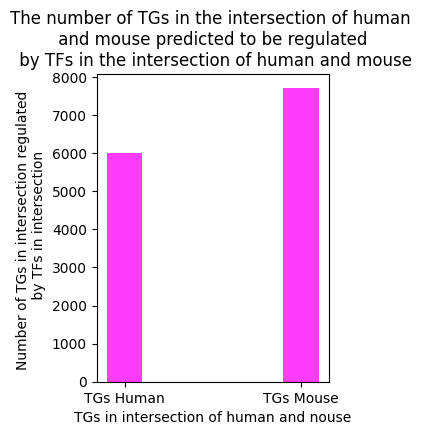

In [72]:
tf_human_num = len(np_intersect_TG_reg_TF_human)
tf_mouse_num = len(np_intersect_TG_reg_TF_mouse)

courses = ["TGs Human", "TGs Mouse"]
values = [tf_human_num, tf_mouse_num]
  
fig = plt.figure(figsize = (3, 4))
 
# creating the bar plot
plt.bar(courses, values, color =tg_color, 
        width = 0.2)
 
plt.xlabel("TGs in intersection of human and nouse")
plt.ylabel("Number of TGs in intersection regulated \n by TFs in intersection")
plt.title("The number of TGs in the intersection of human \n and mouse predicted to be regulated \n by TFs in the intersection of human and mouse")
plt.show()


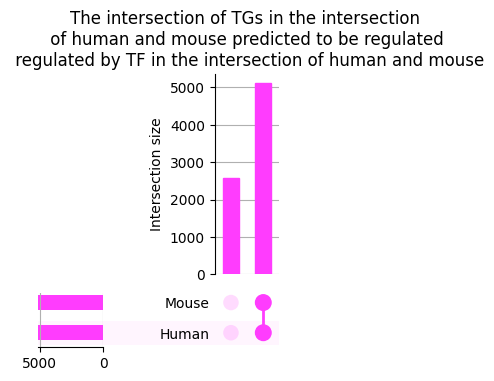

In [73]:
intersection_list_TG_reg_TF_inter = np.intersect1d(np_intersect_TG_reg_TF_mouse, np_intersect_TG_reg_TF_human)
#print("Intersection:", intersection_list_TG_reg_TF_inter)
#print(len(intersection_list))

# Define the subset counts
tf_human_num = len(np_intersect_TG_reg_TF_human)
tf_mouse_num = len(np_intersect_TG_reg_TF_mouse)
inter_num = len(intersection_list_TG_reg_TF_inter)

# Create a data frame with zeros
data = pd.DataFrame(np.zeros((tf_mouse_num, 2), dtype=int), columns=['Human', 'Mouse'])

# Set values to 1 based on subset counts
index = 0
data.loc[index:inter_num-1, 'Human'] = 1
data.loc[index:inter_num-1, 'Mouse'] = 1

upset_data = data[['Human', 'Mouse']]
example = upset_data.groupby(['Human', 'Mouse']).size()
upset = UpSet(example, facecolor=tg_color)
upset.plot()

plt.title('The intersection of TGs in the intersection \n of human and mouse predicted to be regulated \n regulated by TF in the intersection of human and mouse')
plt.show()

In [302]:
unique_tgs = np.unique(np.array(mouse_intestine_tgs['Symbol'].dropna()))

for Symbol in unique_tgs:
    print(Symbol)

0610005C13RIK
0610009E02RIK
0610009L18RIK
0610012D04RIK
0610031O16RIK
0610039K10RIK
0610040B10RIK
0610040F04RIK
1110002J07RIK
1110002L01RIK
1110003F10RIK
1110020A21RIK
1110028F11RIK
1110028F18RIK
1110035H17RIK
1110038B12RIK
1110046J04RIK
1200007C13RIK
1500002C15RIK
1500005C15RIK
1500011B03RIK
1500015A07RIK
1500035N22RIK
1600010M07RIK
1600017P15RIK
1600019K03RIK
1600029O15RIK
1700001D01RIK
1700001G11RIK
1700001G17RIK
1700001K19RIK
1700001L05RIK
1700003D09RIK
1700003G18RIK
1700003M07RIK
1700006J14RIK
1700007E05RIK
1700008B11RIK
1700008J07RIK
1700009C05RIK
1700009J07RIK
1700010B13RIK
1700013A02RIK
1700013D24RIK
1700013G24RIK
1700015O11RIK
1700016A09RIK
1700016B15RIK
1700016G22RIK
1700016P03RIK
1700018A14RIK
1700018A23RIK
1700018L02RIK
1700019A23RIK
1700020A23RIK
1700020G03RIK
1700020G17RIK
1700020L13RIK
1700020N01RIK
1700020N18RIK
1700021F13RIK
1700021J08RIK
1700021P04RIK
1700022A21RIK
1700022H16RIK
1700022N22RIK
1700023H06RIK
1700025C18RIK
1700025M24RIK
1700025N23RIK
1700026J14RIK
170002

### Alignment

In [158]:
# get seqs
# translating dna seq into protein seq
# alignment
human_intestine = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/human_embryo_stem/dcg.tsv", sep="\t")
mouse_intestine = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/mouse_embryo_stem/dcg.tsv", sep="\t")
data = {
    'human': human_intestine["TF"],
    'mouse': mouse_intestine["TF"],
}
df_no_trans = pd.DataFrame(data)

In [75]:
for key in h2m_dict.keys():
    if "MBD2" in key:
        print(key)

In [159]:
# switching key and value
human_symbol_2_human_ensembl_dict = dict([(value, key) for key, value in human_ensembl_2_human_symbol_dict.items()])
mouse_symbol_2_mosue_ensembl_dict = dict([(value, key) for key, value in mouse_ensembl_2_mouse_symbol_dict.items()])
# tranlating the TF intersect from gene symbols into ensemble ids

intersection_list_TFs_ensemble_human = []
for TF in intersection_list_TFs:
    if TF in human_symbol_2_human_ensembl_dict.keys():
        TF_ensemble = human_symbol_2_human_ensembl_dict[TF]
        intersection_list_TFs_ensemble_human.append(TF_ensemble)
    else:
        if "::" in TF:
            TFs_dimer = TF.split("::")
            for TF in TFs_dimer:
                TF_ensemble = human_symbol_2_human_ensembl_dict[TF]
                intersection_list_TFs_ensemble_human.append(TF_ensemble)
        else:
            print(TF)

intersection_list_TFs_mouse = []
for TF in intersection_list_TFs:
    if TF in h2m_dict.keys():
        TF_mouse = h2m_dict[TF]
        intersection_list_TFs_mouse.append(TF_mouse)
    else:
        if "::" in TF:
            TFs_dimer = TF.split("::")
            for TF in TFs_dimer:
                TF_mouse = h2m_dict[TF]
                intersection_list_TFs_mouse.append(TF_mouse)
        else:
            intersection_list_TFs_mouse.append(TF.upper())
    
intersection_list_TFs_ensemble_mouse= []
for TF in intersection_list_TFs_mouse:
    TF_ensemble = mouse_symbol_2_mosue_ensembl_dict[TF]
    intersection_list_TFs_ensemble_mouse.append(TF_ensemble)

In [160]:
from Bio.Seq import Seq

def get_dna_sequence(ensembl_id):
    base_url = "https://rest.ensembl.org"
    endpoint = base_url + "/sequence/id/" + ensembl_id + "?"
    response = requests.get(endpoint, headers={ "Content-Type" : "text/plain"})
    
    if not response.ok:
        response.raise_for_status()
        sys.exit()
    return response.text

def get_strand(ensembl_id):
    base_url = "https://rest.ensembl.org"
    #/overlap/id/ENSG00000157764?content-type=application/json;feature=gene
    endpoint = base_url + "/overlap/id/"+ ensembl_id + "?feature=gene"
    response = requests.get(endpoint, headers={ "Content-Type" : "application/json"})
    
    if not response.ok:
        response.raise_for_status()
        sys.exit()
    else:
        data = response.json()
        strand = data[0]['strand']
        return strand


dna_seqs_human = []
prot_seqs_human = []
for TF in intersection_list_TFs_ensemble_human:
    dna_sequence = Seq(get_dna_sequence(TF))
    strand = get_strand(TF)
    # reverse?
    if strand == -1:
        dna_sequence = dna_sequence.reverse_complement()
    dna_seqs_human.append(dna_sequence)
    
    protein_sequence = dna_sequence.translate()
    prot_seqs_human.append(protein_sequence)
    
dna_seqs_mouse = []
prot_seqs_mouse  = []
for TF in intersection_list_TFs_ensemble_mouse:
    dna_sequence = Seq(get_dna_sequence(TF))
    strand = get_strand(TF)
    # reverse?
    if strand == -1:
        dna_sequence = dna_sequence.reverse_complement()
    dna_seqs_mouse.append(dna_sequence)
    
    protein_sequence = dna_sequence.translate()
    prot_seqs_mouse.append(protein_sequence)


C:\Users\Hisel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\Bio\Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [188]:
len(dna_seqs_mouse)

125

In [78]:
df_alignment = pd.DataFrame.from_dict(data, orient='index')

In [81]:
df_alignment

0     
TF                                                                ZFX  \
Human_ENsemble_IDs                                    ENSG00000005889   
Mouse_ENsemble_IDs                                 ENSMUSG00000079509   
dna_seq_human       (C, C, T, A, T, A, T, G, C, A, C, C, A, G, T, ...   
dna_seq_mouse       (A, C, A, C, A, C, C, G, C, A, C, A, C, A, C, ...   
protein_seq_human   (P, I, C, T, S, D, M, F, L, G, A, I, I, S, V, ...   
protein_seq_mouse   (T, H, R, T, H, T, H, L, R, R, E, G, G, L, R, ...   

                                                                  1     
TF                                                              ZFP57  \
Human_ENsemble_IDs                                    ENSG00000204644   
Mouse_ENsemble_IDs                                 ENSMUSG00000036036   
dna_seq_human       (T, C, A, G, T, C, A, G, A, A, A, G, G, C, C, ...   
dna_seq_mouse       (A, T, T, T, G, T, C, C, T, A, T, A, G, T, G, ...   
protein_seq_human   (S, V, R, K, A, I, Y, L, C, F, K, M, L, T, A, ...   
protein_seq_mouse   (I, C, P, I, V, F, D, C, V, L, G, L, P, A, G, ...   

                                                                  2     
TF                                                              IKZF1  \
Human_ENsemble_IDs                                    ENSG00000185811   
Mouse_ENsemble_IDs                                 ENSMUSG00000018654   
dna_seq_human       (T, T, T, C, A, C, C, A, A, G, G, A, G, T, C, ...   
dna_seq_mouse       (G, A, A, A, A, A, A, T, G, T, A, T, T, A, G, ...   
protein_seq_human   (F, H, Q, G, V, I, T, S, K, T, F, Y, F, D, R, ...   
protein_seq_mouse   (E, K, M, Y, *, K, G, L, E, T, I, L, H, I, N, ...   

                                                                  3     
TF                                                              FOXO4  \
Human_ENsemble_IDs                                    ENSG00000184481   
Mouse_ENsemble_IDs                                 ENSMUSG00000042903   
dna_seq_human       (G, C, A, G, A, T, G, G, C, T, G, C, C, C, C, ...   
dna_seq_mouse       (G, C, C, T, C, A, G, G, T, T, T, A, A, A, A, ...   
protein_seq_human   (A, D, G, C, P, G, E, W, *, T, E, T, S, G, G, ...   
protein_seq_mouse   (A, S, G, L, K, E, Q, E, A, E, *, E, G, A, E, ...   

                                                                  4     
TF                                                               SOX4  \
Human_ENsemble_IDs                                    ENSG00000124766   
Mouse_ENsemble_IDs                                 ENSMUSG00000076431   
dna_seq_human       (T, T, T, A, G, G, G, T, T, C, A, G, T, T, C, ...   
dna_seq_mouse       (T, T, T, A, G, G, G, T, T, C, A, G, T, T, C, ...   
protein_seq_human   (F, R, V, Q, F, Q, L, I, L, F, P, S, Q, K, K, ...   
protein_seq_mouse   (F, R, V, Q, F, Q, L, I, L, F, P, S, Q, K, K, ...   

                                                                  5     
TF                                                        ARNT::HIF1A  \
Human_ENsemble_IDs                                    ENSG00000143437   
Mouse_ENsemble_IDs                                 ENSMUSG00000015522   
dna_seq_human       (T, T, T, A, A, A, T, T, T, C, A, C, T, C, A, ...   
dna_seq_mouse       (G, G, G, G, T, G, G, G, C, G, T, C, C, G, C, ...   
protein_seq_human   (F, K, F, H, S, F, *, S, R, K, G, H, T, G, G, ...   
protein_seq_mouse   (G, V, G, V, R, H, L, G, F, R, G, S, G, G, G, ...   

                                                                  6     
TF                                                               PDX1  \
Human_ENsemble_IDs                                    ENSG00000100644   
Mouse_ENsemble_IDs                                 ENSMUSG00000021109   
dna_seq_human       (A, G, T, G, C, A, C, A, G, T, G, C, T, G, C, ...   
dna_seq_mouse       (T, A, A, G, C, T, G, G, A, A, G, G, T, T, T, ...   
protein_seq_human   (S, A, Q, C, C, L, V, *, G, D, R, R, I, T, L, ...   
protein_seq_mouse   (*, A, G, R, F, V, V, F, 

In [80]:
data = {
    'TF': intersection_list_TFs,
    'Human_ENsemble_IDs': intersection_list_TFs_ensemble_human,
    'Mouse_ENsemble_IDs': intersection_list_TFs_ensemble_mouse,
    #'alignmant_score_dna': mouse_intestine["TF"],
    #'alignmant_score_protein': mouse_intestine["TF"],
    'dna_seq_human': dna_seqs_human,
    'dna_seq_mouse': dna_seqs_mouse,
    'protein_seq_human':prot_seqs_human,
    'protein_seq_mouse': prot_seqs_mouse
}
df_alignment = pd.DataFrame.from_dict(data, orient='index')
df_alignment.to_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/alignment/alignmant_mouse_human.csv")

## Heatmaps

In [161]:
dna_seq_len = []
prot_seq_len = []
dna_gc = []

def get_GC(seq):
    gc = seq.upper().count('G') + seq.upper().count('C')
    return gc

for dna_human_seq, dna_mouse_seq, prot_human_seq, prot_mouse_seq in zip(dna_seqs_human, dna_seqs_mouse, prot_seqs_human, prot_seqs_mouse):
    dna_seq_len.append((len(dna_human_seq) + len(dna_mouse_seq))/2)
    prot_seq_len.append((len(prot_human_seq) + len(prot_mouse_seq))/2)
    dna_gc.append((get_GC(dna_human_seq) + get_GC(dna_mouse_seq))/2)


In [372]:
df_scores_protein = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/alignment/protein_scores_alignment.csv")
df_scores_dna = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/alignment/dna_scores_alignment.csv")

df_scores_protein = df_scores_protein[df_scores_protein.TF.isin(['FOSB']) == False]
#new_row= pd.DataFrame([{'TF': 'FOSB', 'Conservation_Score': np.nan, 'Alignment_Score': 0.8}])
#df_scores_dna = pd.concat([df_scores_dna, new_row], ignore_index=True)

df_scores_protein_sort = df_scores_protein.sort_values(by='TF')
df_scores_protein_sort.reset_index(drop=True, inplace=True)
df_scores_dna_sort = df_scores_dna.sort_values(by='TF')
df_scores_dna_sort.reset_index(drop=True, inplace=True)

In [373]:
df_scores_dna_sort

TF  Conservation_Score  Alignment_Score
0           AIRE            0.844607           2219.0
1         ARID5B            0.841085           3577.0
2           ARNT            0.836177          45134.0
3    ARNT::HIF1A            0.834206          41351.0
4         BARHL1            0.845923           1621.0
..           ...                 ...              ...
118       ZBTB7A            0.836615          58107.0
119         ZEB1            0.834492          12799.0
120        ZFP57            0.835535           5741.0
121          ZFX            0.833917          36108.0
122          NaN            0.843768           8336.0

[123 rows x 3 columns]

In [374]:
len(list(df_scores_protein["Conservation_Score"]))

123

In [375]:
#df_scores_protein_without = df_scores_protein[~df_scores_protein['TF'].isin(['KLF5', 'FOSB', np.nan])]
#df_scores_protein_without = df_scores_protein[df_scores_protein.TF.isin(['KLF5', 'FOSB']) == False]
data = {
    'TF' : df_scores_dna_sort["TF"],
    'Protein Alignment Conservation Score': df_scores_protein_sort["Conservation_Score"],
    'DNA Alignment Conservation Score': df_scores_dna_sort["Conservation_Score"]
}
df_conserv = pd.DataFrame(data)

In [376]:
np.nanmean(np.array(df_conserv['Protein Alignment Conservation Score']))

0.835366060485963

In [377]:
np.nanmean(np.array(df_conserv['DNA Alignment Conservation Score']))

0.8379301391632251

In [378]:
np.nanmax(np.array(df_conserv['Protein Alignment Conservation Score']))

0.8419125702811251

In [315]:
heatmap_data

TF                                        AIRE    ARID5B      ARNT   
DNA Alignment Conservation Score      0.844607  0.841085  0.836177  \
Protein Alignment Conservation Score  0.832839  0.834456  0.835658   

TF                                    ARNT::HIF1A    BARHL1     BARX1   
DNA Alignment Conservation Score         0.834206  0.845923  0.834807  \
Protein Alignment Conservation Score     0.836901  0.839070  0.833873   

TF                                       BATF3      CBFB      CDX2     CEBPA   
DNA Alignment Conservation Score      0.843008  0.835398  0.842266  0.838497  \
Protein Alignment Conservation Score  0.837941  0.835318  0.833485  0.833281   

TF                                    ...    TCF7L2     TCFL5    TFAP2A   
DNA Alignment Conservation Score      ...  0.839924  0.841013  0.837602  \
Protein Alignment Conservation Score  ...  0.836076  0.834965  0.831061   

TF                                      TFAP2B    TFAP2C       WT1    ZBTB7A   
DNA Alignment Conservation Score      0.840478  0.838521  0.842163  0.836615  \
Protein Alignment Conservation Score  0.836738  0.835261  0.837179  0.827905   

TF                                        ZEB1     ZFP57       ZFX  
DNA Alignment Conservation Score      0.834492  0.835535  0.833917  
Protein Alignment Conservation Score  0.833881  0.836664  0.836724  

[2 rows x 121 columns]

In [379]:
mouse_run_intersect = ['GABPA',
 'GATA3',
 'GRHL2',
 'HOXA5',
 'HOXB5',
 'HOXB8',
 'HOXD13',
 'HOXD3',
 'HOXD9',
 'LEF1',
 'LHX2',
 'NR2E1',
 'NR2F2',
 'PITX1',
 'SIX2',
 'SP1',
 'SP3',
 'TBX3',
 'TFAP2A',
 'TGIF1',
 'ZIC3']

human_run_intersect = ['ALX3',
 'EMX1',
 'EN1',
 'EOMES',
 'FOXA2',
 'FOXB1',
 'FOXE1',
 'GBX2',
 'HIF1A',
 'HOXB2',
 'MXI1',
 'MYCN',
 'OTX2',
 'PBX2',
 'PITX1',
 'TBX1',
 'TBX18',
 'TBX5']

both_runs = mouse_run_intersect + human_run_intersect

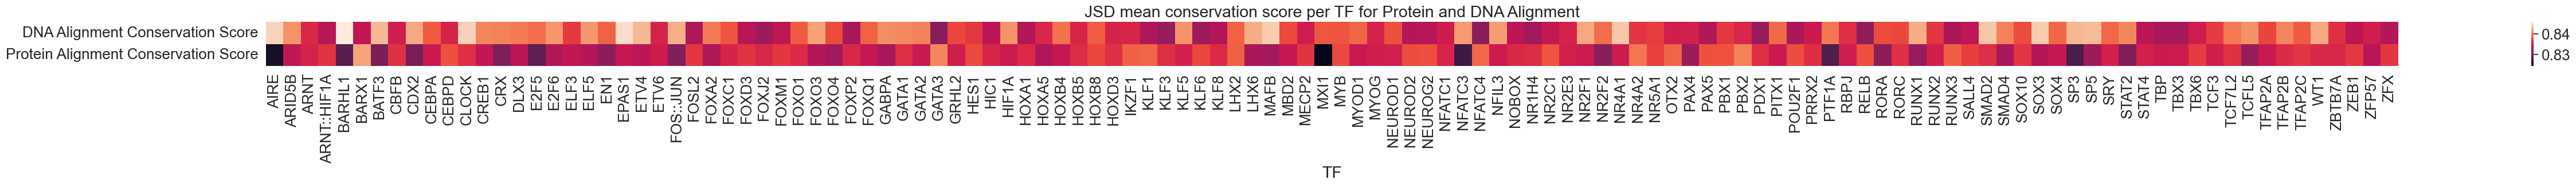

In [382]:
#df_conserv = df_scores_protein.drop(columns=['Alignment_Score_Norm', 'Alignment_Score'], axis=1)
#df_conserv.set_index('TF', inplace=True)

plt.figure(figsize=(60,1))
heatmap_data = df_conserv.pivot_table(index=None, columns='TF')
ax = sns.heatmap(heatmap_data, yticklabels=["DNA Alignment Conservation Score", "Protein Alignment Conservation Score"])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Make specific x-ticks bold
#ticklabels = ax.get_xticklabels()
#for label in ticklabels:
#    if label.get_text() in both_runs:
#        label.set_fontweight('bold')
        
#ax.set_yticklabels(ax.get_yticklabels(), rotation=1)
plt.title("JSD mean conservation score per TF for Protein and DNA Alignment")
plt.show()

#sns.heatmap()

In [383]:
# Calculate the mean conservation score
mean_conservation_score = df_conserv[df_conserv['TF'].isin(both_runs)]['DNA Alignment Conservation Score'].mean()
mean_conservation_score

0.8378043624437506

In [369]:
sorted_df = df_conserv.sort_values(by='DNA Alignment Conservation Score')

# Get the five genes with the lowest conservation scores
lowest_score_genes = sorted_df.head(5)

print("Five genes with the lowest conservation scores:")
print(lowest_score_genes)

Five genes with the lowest conservation scores:
        TF  Protein Alignment Conservation Score   
39   GATA3                              0.840518  \
70  NFATC4                              0.839070   
92    RELB                              0.838046   
52    KLF3                              0.836614   
86    PDX1                              0.836614   

    DNA Alignment Conservation Score  
39                          0.831819  
70                          0.831992  
92                          0.832232  
52                          0.832564  
86                          0.832564  


In [371]:
0.8419125702811251 - 0.824526

0.017386570281125113

In [ ]:
MXI1 0.824526  \
AIRE                              0.825849   
NFATC3                              0.827905 

GATA3                              0.840518  \
70  NFATC4                              0.839070   
92    RELB                              0.838046  

In [359]:
#df_scores_protein_without = df_scores_protein[~df_scores_protein['TF'].isin(['KLF5', 'FOSB', np.nan])]
#df_scores_protein_without = df_scores_protein[df_scores_protein.TF.isin(['KLF5', 'FOSB']) == False]
df_scores_protein_sort['Alignment_Score_Norm'] = df_scores_protein_sort.apply(lambda row: row['Alignment_Score'] / prot_seq_len[row.name], axis=1)
df_scores_dna_sort['Alignment_Score_Norm'] = df_scores_dna_sort.apply(lambda row: row['Alignment_Score'] / dna_seq_len[row.name], axis=1)

In [360]:

data = {
    'TF' : df_scores_dna_sort["TF"],
    'Protein Alignment norm Alignment Score': df_scores_protein_sort["Alignment_Score_Norm"],
    'DNA Alignment norm Alignment Score': df_scores_dna_sort["Alignment_Score_Norm"]
}
df_align_heat = pd.DataFrame(data)

<function matplotlib.pyplot.show(close=None, block=None)>

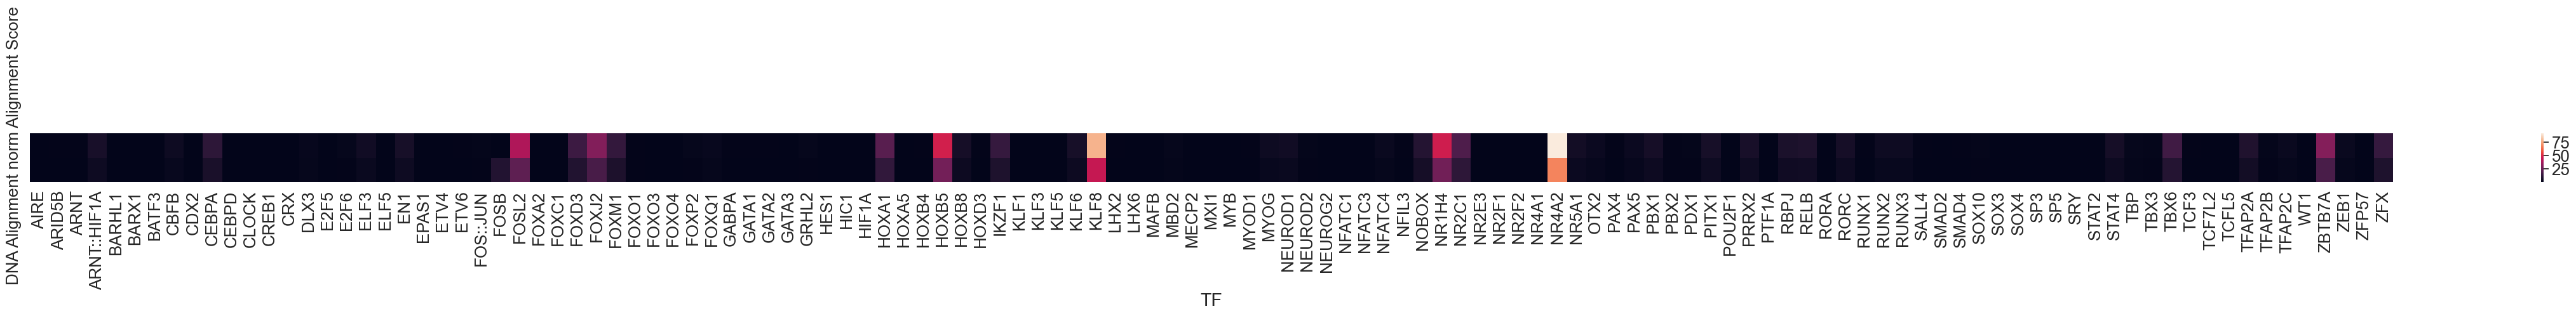

In [361]:
#df_align = df_scores_protein.drop(columns=['Conservation_Score', 'Alignment_Score'], axis=1)

plt.figure(figsize=(60,1))
heatmap_data = df_align_heat.pivot_table(index=None, columns='TF')
sns.heatmap(heatmap_data)
plt.show
#sns.heatmap()

In [220]:
count = 1
for TF in df_alignment.iloc[0].tolist():
    print(str(count) + ": " + str(TF))
    count += 1

1: ZFX
2: ZFP57
3: IKZF1
4: FOXO4
5: SOX4
6: ARNT::HIF1A
7: PDX1
8: BATF3
9: HES1
10: MYB
11: POU2F1
12: FOXJ2
13: NEUROD1
14: CEBPD
15: NFATC3
16: NOBOX
17: FOXQ1
18: CLOCK
19: NEUROG2
20: ELF5
21: RUNX2
22: KLF8
23: NFATC4
24: GABPA
25: KLF1
26: CREB1
27: NR1H4
28: HOXA1
29: BARX1
30: MAFB
31: E2F5
32: GATA3
33: NR5A1
34: WT1
35: MYOG
36: STAT2
37: TCF3
38: TFAP2B
39: NFATC1
40: PITX1
41: SMAD2
42: FOXP2
43: RELB
44: MYOD1
45: EPAS1
46: ZBTB7A
47: FOS::JUN
48: LHX2
49: FOXC1
50: FOXO1
51: ARID5B
52: ETV6
53: FOSL2
54: HOXB5
55: EN1
56: RORA
57: CDX2
58: FOSB
59: KLF5
60: TCFL5
61: ZEB1
62: HOXD3
63: KLF6
64: HOXB8
65: MECP2
66: RUNX1
67: PAX5
68: NR4A2
69: TFAP2A
70: PBX2
71: ELF3
72: SRY
73: DLX3
74: MXI1
75: FOXO3
76: ARNT
77: PBX1
78: FOXD3
79: TBX6
80: SOX3
81: NFIL3
82: CRX
83: SOX10
84: NR2E3
85: ETV4
86: GATA2
87: TCF7L2
88: E2F6
89: RBPJ
90: SALL4
91: PRRX2
92: RORC
93: CEBPA
94: FOXA2
95: BARHL1
96: NR2F1
97: LHX6
98: SMAD4
99: GATA1
100: TBX3
101: TFAP2C
102: GRHL2
103: PAX

In [ ]:
df_done = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/alignment/done.rtf", sep="\t")

In [198]:
df_done = pd.read_csv("C:/Users/Hisel/Documents/Studium/Semester6/Bachelor/data/alignment/done.rtf", sep="\t")

In [212]:
done_list = list(df_done['{\\rtf1\\ansi\\ansicpg1252\\deff0\\nouicompat\\deflang1031{\\fonttbl{\\f0\\fnil\\fcharset0 Calibri;}}'])
done_tf_list = []
for entry in done_list:
    #print(entry)
    entry = str(entry)
    if not entry == "nan":
        entry_list = entry.split(" ")
        #print(entry_list)
        for file in entry_list:
            if ".fasta" in file:
                done_tf_list.append(file.split("_")[0].strip())
    else:
        print(entry)

nan


In [213]:
len(done_tf_list)

122

In [219]:
list(df_scores_protein["TF"])[37:39]

['KLF5', 'NR2E3']

In [217]:
elements_not_in_done_tf_list = [elem for elem in list(df_scores_protein["TF"]) if elem not in done_tf_list]

elements_not_in_done_tf_list

['KLF5', 'FOSB', nan]